# Project 1: Enhancer for Scanned Images

**Input**: portable pix map (ppm) color image(s) in ASCII-format  
**Output**: cleaned ppm image(s) in ASCII-format  
**Motivation**: free tool (**executable**) for improving the quality of scanned documents before printing (or sending) them  
**Keywords**: noise reduction, background removal, image filter  

### idea

Because Python is easier for me (though much slower compared to c++ 3min: 1s(without speedup)), I started by trying a few different ways to enhance the scanned images with Python.    
+ (1) gamma correction 
+ (2) average filter
+ (3) Histogram linearization
+ (4) gamma correction  + Histogram linearization
+ (5) binary threshold
+ (6) **adaptive threshold mean C**


After finding the most efficient way (**adaptive threshold mean C**), I used c++ and tried to speed it up.


In [3]:
import glob
import urllib.request

%matplotlib inline
import matplotlib.pyplot as plt

import imageio
import numpy as np

In [8]:
image_filter = 'in.jpg'

## (1) gamma correction

In [3]:
gamma = 0.5

In [10]:
# load image
image_path = np.random.choice(glob.glob(image_filter))
image = imageio.imread(image_path)

In [65]:
image_max = np.float32(np.max(image))  # Maximum bestimmen
image_min = np.float32(np.min(image))  # Minimum bestimmen
image = (np.float32(image) - image_min) / (image_max-image_min)

In [66]:
def ex1_gammacorrect(image, gamma):
    return image ** gamma

In [67]:
image_corrected = ex1_gammacorrect(image, gamma=gamma)

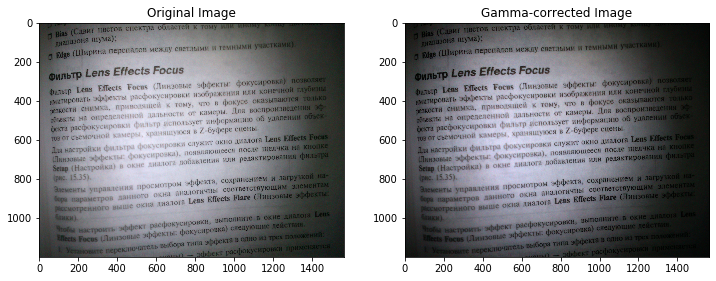

In [68]:
fig, axes = plt.subplots(1, 2, figsize=(12, 12))
axes[0].set_title('Original Image')
axes[0].imshow(image, cmap='gray')
axes[1].set_title('Gamma-corrected Image')
axes[1].imshow(image_corrected, cmap='gray')
plt.show()

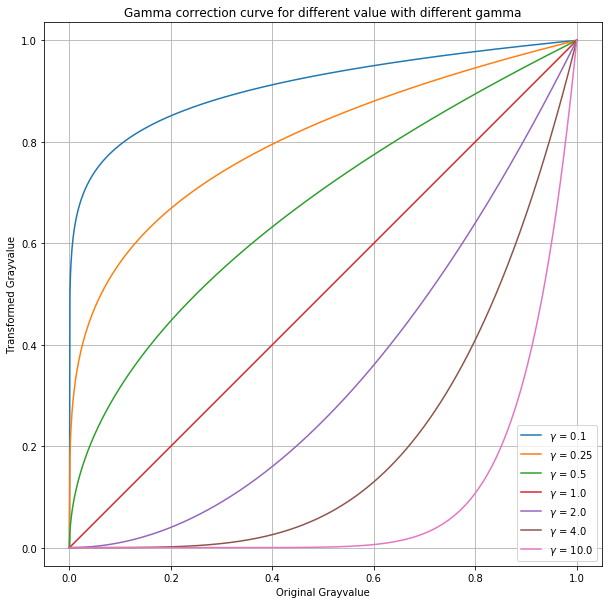

In [69]:
gammas = [0.1, 0.25, 0.5, 1.0, 2.0, 4.0, 10.0]
X = np.linspace(0, 1, 1000)

plt.figure(figsize=(10, 10))
for gamma in gammas:
    plt.plot(X, X ** gamma, label=f'$\gamma$ = {gamma}')
plt.xlabel('Original Grayvalue')
plt.ylabel('Transformed Grayvalue')
plt.legend()
plt.grid()
plt.axis('equal')
plt.title('Gamma correction curve for different value with different gamma')
#plt.savefig('./gamma_correct_curve.png',dpi = 500, bbox_inches = 'tight')
plt.show()

### gamma correct with a series of gamma

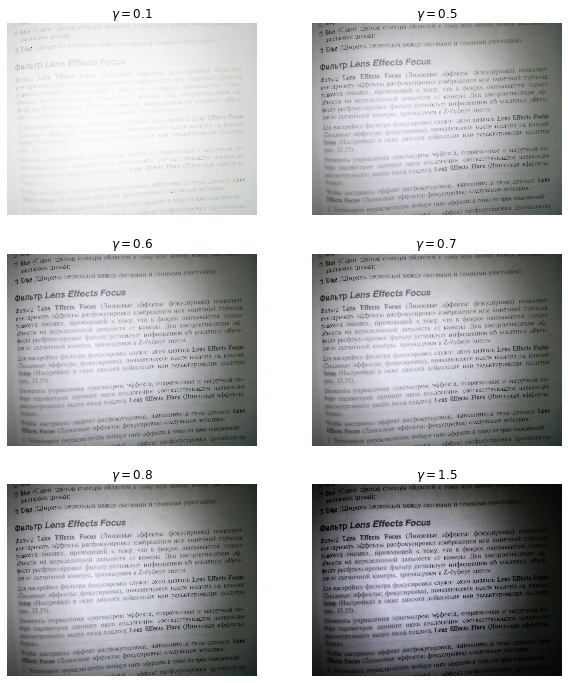

In [70]:
gammas = [0.1, 0.5, 0.6 ,0.7, 0.8, 1.5]

fig, axes = plt.subplots(3,2, figsize=(10, 12))
for gamma, ax in zip(gammas, axes.ravel()):
    ax.imshow(ex1_gammacorrect(image, gamma=gamma), cmap='gray')
    ax.set_title(f'$\gamma = {gamma}$')
    ax.axis('off')

plt.savefig('./gamma_correct.png',dpi = 200, bbox_inches = 'tight')
plt.show()

#### seems gamma = 0.55 enhance the image better, let's look closer at it

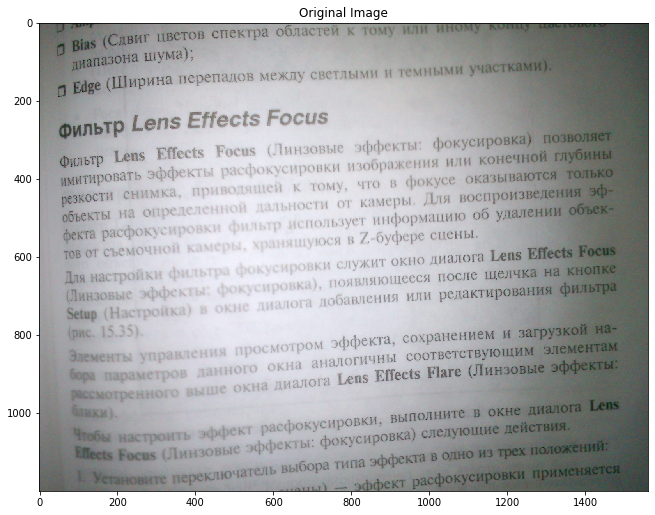

In [233]:

img = ex1_gammacorrect(image, gamma=0.55)

plt.figure('Convolution: image comparison', figsize=(24, 12))
plt.subplot(1,2,1, title='Original Image')
plt.imshow(img, cmap='gray', vmin=0, vmax=1)

plt.show()

#### but not good enough ,the text is blurry, with shadows around the edges 

## (2) average filter

In [39]:
# a average - filter maask
w, h = 3, 3
A_avg = np.ones((3,3)) / 9


In [44]:
image_path = np.random.choice(glob.glob(image_filter))
image = imageio.imread(image_path)

In [45]:
#image = np.asarray(image, dtype=np.float32) / 255

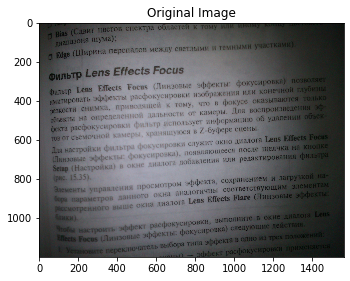

In [46]:
plt.figure('Load original Image', figsize=(12, 6))
plt.subplot(1,2,1, title='Original Image')
plt.imshow(image, cmap='gray', vmin=0, vmax=1)

plt.show()

#### to do the later steps, we need to change the image into a gray scale image

In [5]:
gray_image = np.zeros([image.shape[0],image.shape[1]])
for y in range(image.shape[0]):
    for x in range(image.shape[1]):
        gray_image[y,x]= 0.2989 * image[y,x,0] + 0.5870 * image[y,x,1] + 0.1140 * image[y,x,2] 
gray_image  = np.round(gray_image)
gray_image = gray_image.astype(int)           

#### convolve image with average filter mask

In [44]:
%%time
def ex2_convolve(image, filter_mask):
    convolved_image = np.zeros_like(image)
    offset_y = filter_mask.shape[0] // 2
    offset_x = filter_mask.shape[1] // 2
    for cy in range(convolved_image.shape[0]):
        for cx in range(convolved_image.shape[1]):
            for fy in range(filter_mask.shape[0]):
                img_y = cy + fy - offset_y
                if 0 <= img_y < image.shape[0]:
                    for fx in range(filter_mask.shape[1]):
                        img_x = cx + fx - offset_x
                        if 0 <= img_x < image.shape[1]:
                            convolved_image[cy, cx] += image[img_y, img_x] * filter_mask[fy, fx]
    return convolved_image

convolved_image = ex2_convolve(gray_image, A_avg)

Wall time: 2min 15s


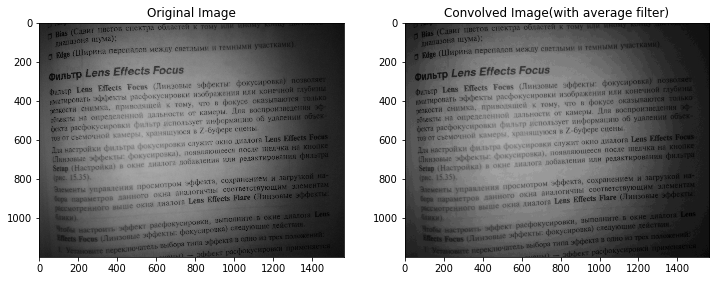

In [48]:
plt.figure('Convolution: image comparison', figsize=(12, 6))
plt.subplot(1,2,1, title='Original Image')
plt.imshow(gray_image, cmap='gray', vmin=0, vmax=255)
plt.subplot(1,2,2, title='Convolved Image(with average filter)')
plt.imshow(convolved_image, cmap='gray', vmin=0, vmax=255)
#plt.savefig('./convolve with average filter.png',dpi = 500, bbox_inches = 'tight')
plt.show()

the shadow in the edge seems darker, this method is not useful for this case

## (3) Histogram linearization

 next, we try Histogram linearization

In [32]:
def ex3_histogram(image):
    histogram = [0] * 256
    for y in range(image.shape[0]):
        for x in range(image.shape[1]):
            value = image[y,x]
            histogram[value] += 1
    return histogram

In [33]:
def ex3_cumulative_histogram(image):
    histogram = ex3_histogram(image)
    cumulative_histogram = []
    running_value = 0
    for h in histogram:
        running_value += h
        cumulative_histogram += [running_value]
    return cumulative_histogram

In [50]:
image_histogram = ex3_histogram(gray_image)
image_cumulative_histogram = ex3_cumulative_histogram(gray_image)

In [35]:
def ex3_histogram_linearization(image, cumulative_histogram):
    linearized_image = np.zeros_like(image)
    correction_factor = 255 / cumulative_histogram[-1]
    for y in range(image.shape[0]):
        for x in range(image.shape[1]):
            value = image[y,x]
            linearized_value = round(correction_factor * cumulative_histogram[value])
            linearized_image[y,x] = linearized_value
    return linearized_image

In [51]:
linearized_image = ex3_histogram_linearization(gray_image, image_cumulative_histogram)
linearized_image_cumulative_histogram = ex3_cumulative_histogram(linearized_image)

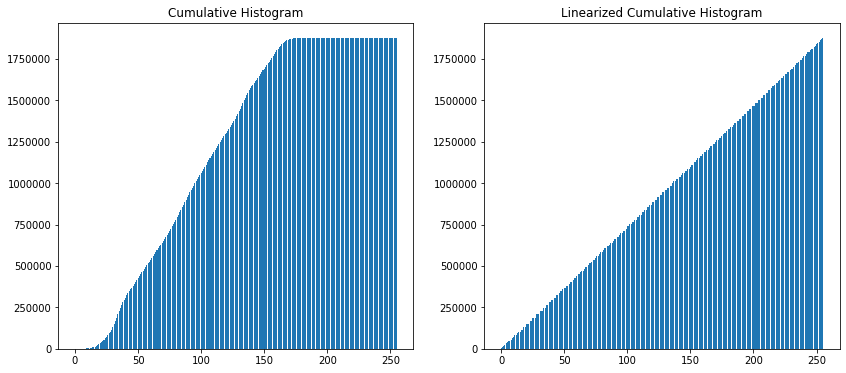

In [52]:
plt.figure('Histogram linearization', figsize=(14, 6))
plt.subplot(1,2,1, title='Cumulative Histogram')
plt.bar(x=range(256), height=image_cumulative_histogram)
plt.subplot(1,2,2, title='Linearized Cumulative Histogram')
plt.bar(x=range(256), height=linearized_image_cumulative_histogram)
#plt.savefig('./Histogram linearization.png',dpi = 500, bbox_inches = 'tight')
plt.show()

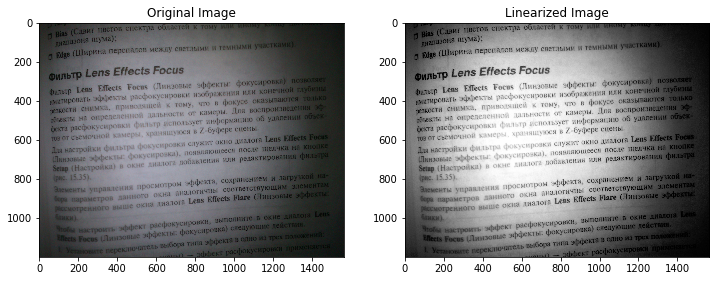

In [53]:
plt.figure('Histogram linearization: image comparison', figsize=(12,6))
plt.subplot(1,2,1, title='Original Image')
plt.imshow(image, cmap='gray')
plt.subplot(1,2,2, title='Linearized Image')
plt.imshow(linearized_image, cmap='gray')
#plt.savefig('./compare_original_linearized.png',dpi = 500, bbox_inches = 'tight')
plt.show()

 what if we use gamma correction on linearlized image?

## (4) gamma correction + Histogram linearization

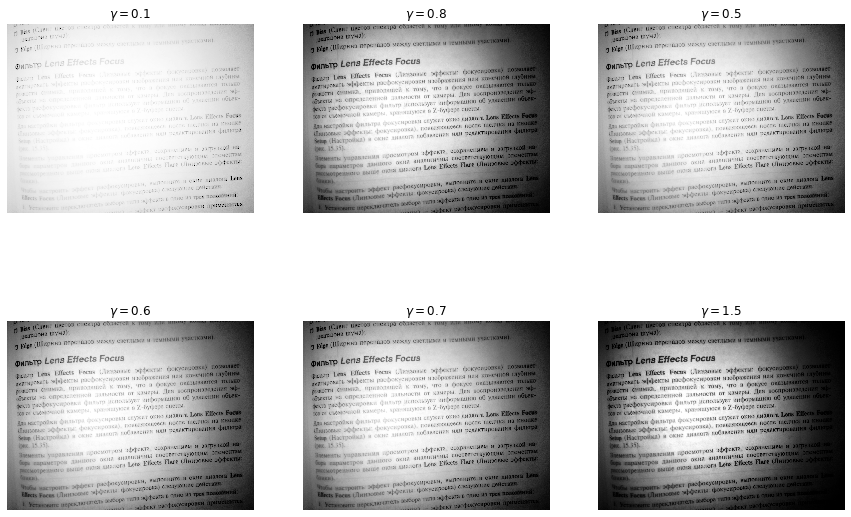

In [74]:
gammas = [0.1, 0.8, 0.5, 0.6 ,0.7 , 1.5]

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
for gamma, ax in zip(gammas, axes.ravel()):
    ax.imshow(ex1_gammacorrect(linearized_image, gamma=gamma), cmap='gray')
    ax.set_title(f'$\gamma = {gamma}$')
    ax.axis('off')
#plt.savefig('./gamma_on_linearlized.png',dpi = 500, bbox_inches = 'tight')
plt.show()

### let's look closer on the image when gamma = 0.2  

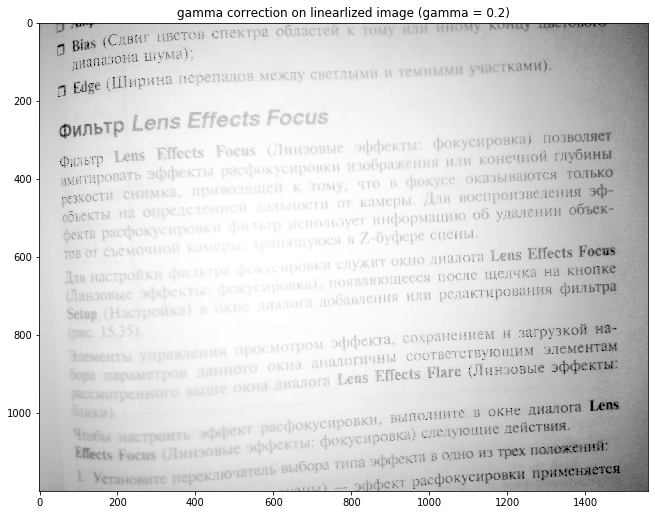

In [75]:
img = ex1_gammacorrect(linearized_image, gamma=0.2)
plt.figure(' his linear+ Gmma', figsize=(24, 12))
plt.subplot(1,2,1, title='gamma correction on linearlized image (gamma = 0.2)')
plt.imshow(img, cmap='gray')

plt.show()

The dark areas in the edges become brighter,  
**but** the bright areas in the center are so bright that they can no longer clearly be seen

## (5) binary threshold
 next step I want to try if I can enhance the image with binary threshold method, becused we can notice in former methods, the text is always blurry, the pictures always look gray, and the text doesn't stand out enough and has a lot of shadows. I would like to know if the text will stand out more if I use binarization threshold to split the image

In [84]:
image_path = np.random.choice(glob.glob(image_filter))
image = imageio.imread(image_path)

In [16]:
gray_image = np.zeros([image.shape[0],image.shape[1]])
for y in range(image.shape[0]):
    for x in range(image.shape[1]):
        gray_image[y,x]= 0.2989 * image[y,x,0] + 0.5870 * image[y,x,1] + 0.1140 * image[y,x,2] 
gray_image  = np.round(gray_image)
gray_image = gray_image.astype(int) 


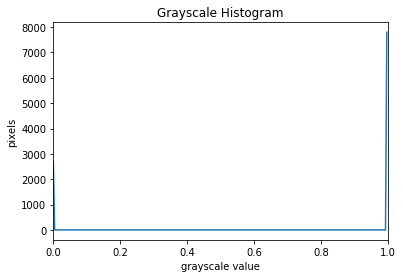

In [54]:
# create a histogram of the blurred grayscale image
histogram, bin_edges = np.histogram(linearized_image, bins=256, range=(0.0, 1.0))

plt.plot(bin_edges[0:-1], histogram)
plt.title("Grayscale Histogram")
plt.xlabel("grayscale value")
plt.ylabel("pixels")
plt.xlim(0, 1.0)
plt.show()

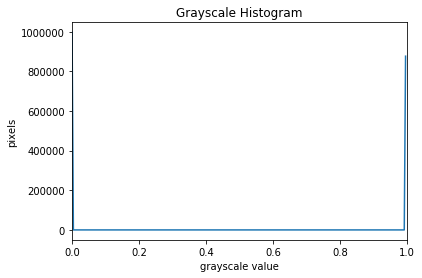

In [28]:
# create a histogram of the blurred grayscale image
histogram, bin_edges = np.histogram(gray_image, bins=256, range=(0.0, 1.0))

plt.plot(bin_edges[0:-1], histogram)
plt.title("Grayscale Histogram")
plt.xlabel("grayscale value")
plt.ylabel("pixels")
plt.xlim(0, 1.0)
plt.show()

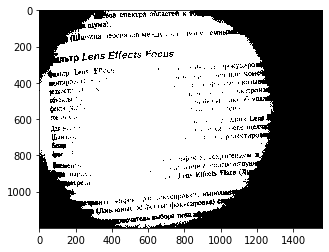

In [56]:
# create a mask based on the threshold
t = 100
binary_mask1 = linearized_image > t

fig, ax = plt.subplots()
plt.imshow(binary_mask1, cmap='gray')
plt.show()

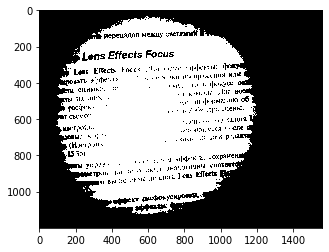

In [57]:
# create a mask based on the threshold
t = 100
binary_mask2 = gray_image > t

fig, ax = plt.subplots()
plt.imshow(binary_mask2, cmap='gray')
plt.show()

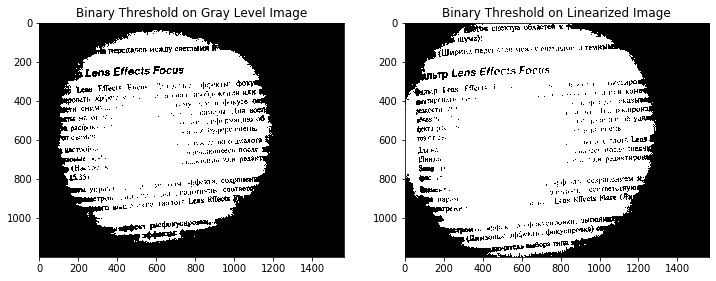

In [59]:
plt.figure('BINARY: image comparison', figsize=(12,6))
plt.subplot(1,2,1, title='Binary Threshold on Gray Level Image')
plt.imshow(binary_mask2, cmap='gray')
plt.subplot(1,2,2, title='Binary Threshold on Linearized Image')
plt.imshow(binary_mask1, cmap='gray')
#plt.savefig('./compare_bin.png',dpi = 500, bbox_inches = 'tight')
plt.show()

We found that this method makes the text clearer, but since our scanned image lighting is stronger in the center and darker at the edges. So the text in the center is emphasized, **but** since the dark areas at the edges are as dark as the text in the center, the edges are all blacked out after binary processing.

Therefore we should split the image into smaller blocks and use a binary threshold segmentation in each block so that the different lighting at the edges and the center can be considered separately.

# (6) adaptive threshold mean C

I firstily use opencv, because it already has the adaptive threshold mean C method, if it works well, we can write our own algorithm.

In [13]:
import cv2
import matplotlib.pyplot as plt


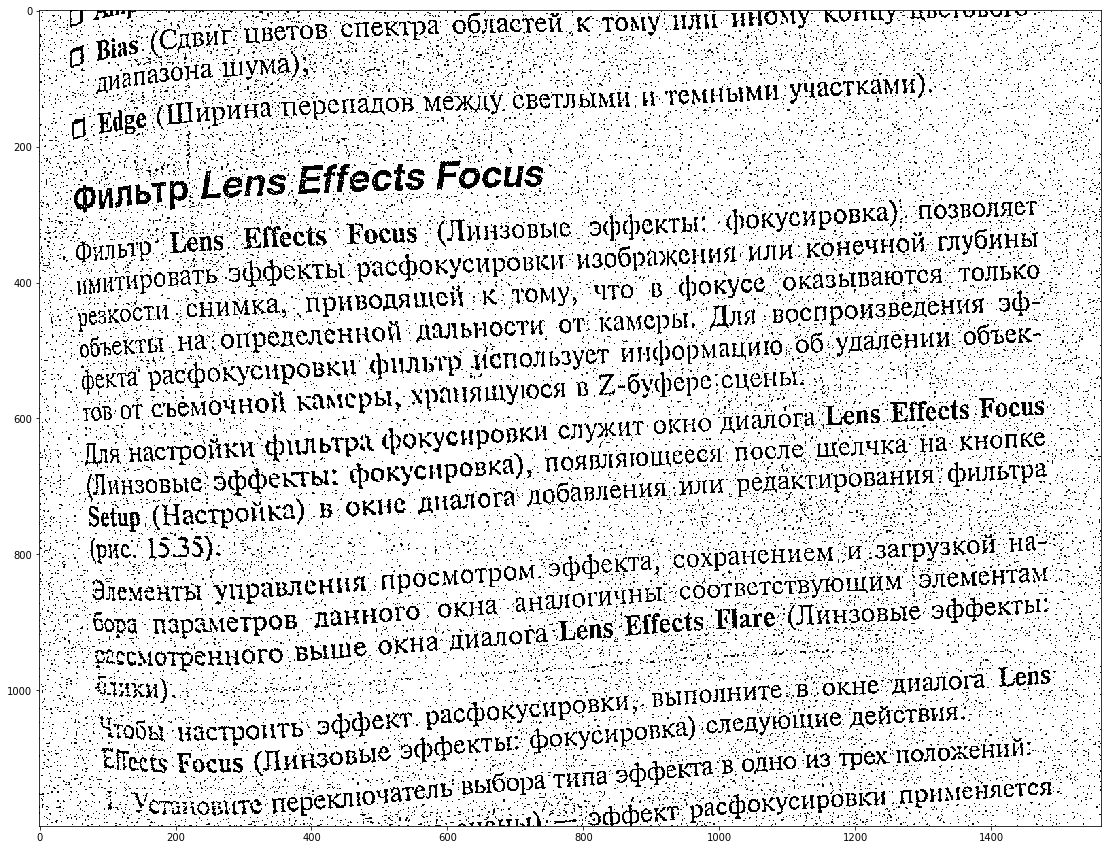

In [80]:
gray_image = gray_image.astype(np.uint8)
th3 = cv2.adaptiveThreshold(gray_image,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,2)
plt.figure(figsize=(20,15))
plt.imshow(th3, cmap="gray")
#plt.savefig('./ada_need_adiust.png',dpi = 500, bbox_inches = 'tight')
plt.show()

In [117]:
gray_image = gray_image.astype(np.uint8)

In [120]:
%%time
th3 = cv2.adaptiveThreshold(gray_image,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,55,8)

Wall time: 35.9 ms


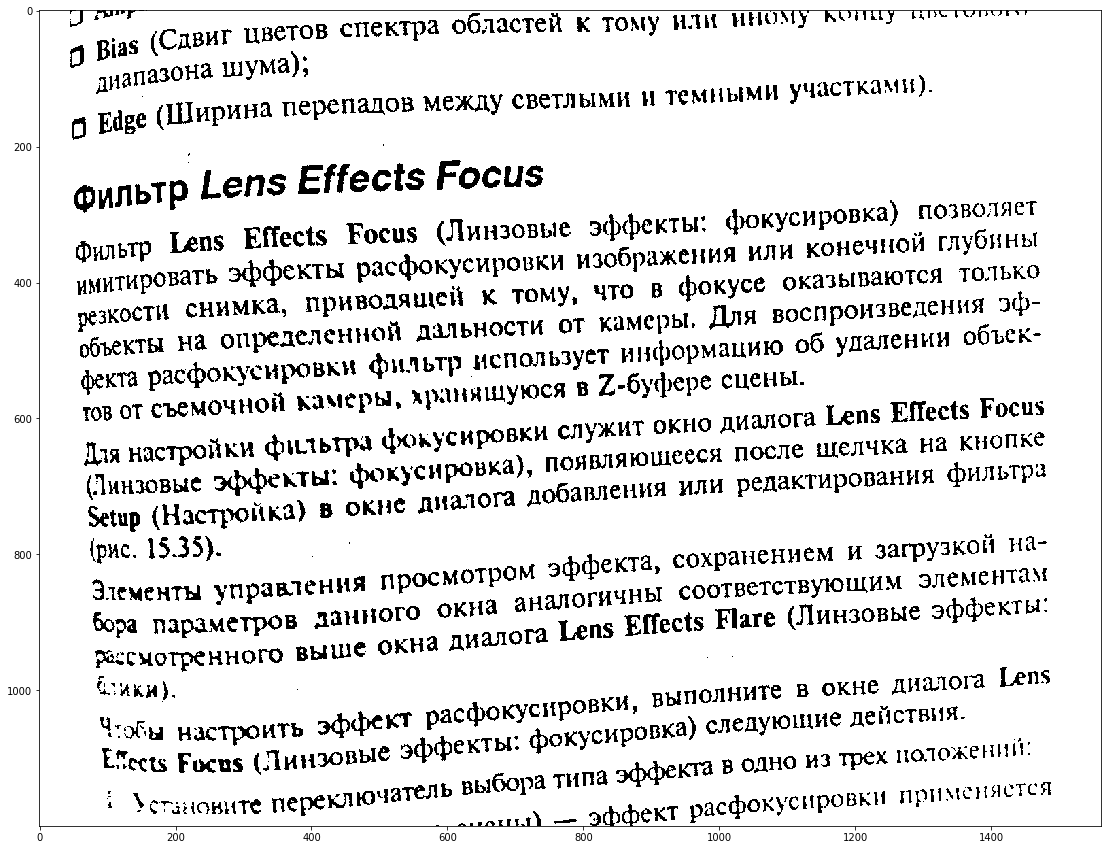

Wall time: 531 ms


In [119]:
%%time
th3 = cv2.adaptiveThreshold(gray_image,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,55,8)
plt.figure(figsize=(20,15))
plt.imshow(th3, cmap="gray")
#plt.savefig('./ada_better.png',dpi = 500, bbox_inches = 'tight')
plt.show()

After adjusting the parameters, we found that this method enhances the text of the scanned image 
# **very well**.  
There are no shadows at the edges and the text all stands out nicely.

## (6) adaptive median filter
I also tried adaptive median filter , it turns out it is as good as adaptive threshold mean C

In [90]:
max_filter = lambda f: f[-1]
min_filter = lambda f: f[0]
median_filter = lambda f: f[len(f)//2] if len(f) % 2 else (f[len(f)//2 - 1] + f[len(f)//2]) / 2

In [91]:
def ex4_adaptive_median_filter(image, Smax):
    filtered_image = np.zeros_like(image)
    for cy in range(filtered_image.shape[0]):
        for cx in range(filtered_image.shape[1]):
            
            zxy = image[cy, cx]
            
            # Phase A
            w = 3
            while w <= Smax:
                
                # Extract w x w neighborhood around this pixel, flatten it into a 1-D sequence, and sort the values.
                offset_y = offset_x = w // 2
                values = sorted(image[max(0, cy-offset_y):cy+offset_y+1, max(0, cx-offset_x):cx+offset_x+1].ravel())
                
                # Compute median, minimum, and maximum of the neighborhood.
                zmed = median_filter(values)
                zmin = min_filter(values)
                zmax = max_filter(values)
                
                # Check if median is an extreme value in the window
                if (zmed > zmin) and (zmed < zmax):
                    
                    # Phase B: only replace extreme values with the median
                    if zxy > zmin and zxy < zmax:
                        filtered_image[cy, cx] = zxy
                    else:
                        filtered_image[cy, cx] = zmed
                    break
                    
                else:
                    
                    # Increase window size
                    w += 2
                    if w > Smax:
                        filtered_image[cy, cx] = zmed
                
    return filtered_image

In [93]:
th3 = th3.astype(np.int64)

In [94]:
%%time
filtered_image = ex4_adaptive_median_filter(th3, 5)

Wall time: 37.8 s


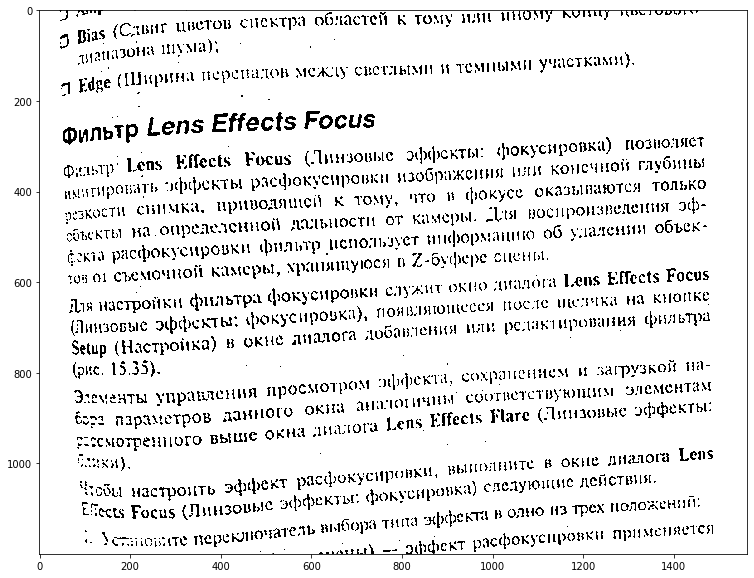

In [95]:
plt.figure(figsize=(20,10))
plt.imshow(filtered_image, cmap="gray")
plt.show()

## write my own adaptive threshold mean C

it is time to write my own adaptive threshold mean C function

In [121]:
def adap_thres_mean_C(image, Max_Value, filter_mask_size, C):
    # build filter mask
    filter_mask = np.ones((filter_mask_size,filter_mask_size)) / (filter_mask_size * filter_mask_size)
    
    convolved_image = np.zeros_like(image)
    offset_y = filter_mask_size // 2
    offset_x = filter_mask_size // 2
    
    # Explicitly zero-pad the original image
    image_pad = np.zeros((image.shape[0] + 2 * offset_y, image.shape[1] + 2 * offset_x), dtype=image.dtype)
    image_pad[offset_y:offset_y+image.shape[0], offset_x:offset_x+image.shape[1]] = image
    
    # Convolve
    for cy in range(convolved_image.shape[0]):
        for cx in range(convolved_image.shape[1]):
            # Extract image patch of the same size as the mask centered around the current pixel,
            # multiply it element-wise with the mask, and accumulate the results.
            patch = image_pad[cy:cy+filter_mask.shape[0], cx:cx+filter_mask.shape[1]]
            T = np.sum(patch * filter_mask) -C
            if image[cy, cx] > T :
                convolved_image[cy, cx] = Max_Value               
            else:
                convolved_image[cy, cx] = 0
    
    return convolved_image 

In [125]:
%%time
convolved_image1 = adap_thres_mean_C(gray_image,255, 55,8)

Wall time: 52.7 s


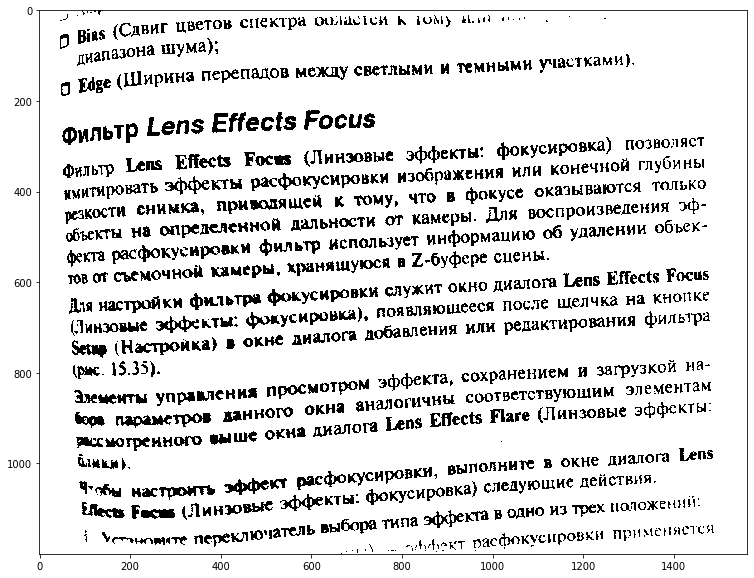

Wall time: 48.4 s


In [122]:
%%time
convolved_image1 = adap_thres_mean_C(gray_image,255, 55,10)
plt.figure(figsize=(20,10))
plt.imshow(convolved_image1, cmap="gray")
plt.show()

now I know with adaptive threshold mean C method can enhance the sacnned image well. But the run time is really long (51s)
I will write this function with **c++** and try to run it in parallel

In [37]:
image_filter1 = 'test1.jpg'
image_filter2 = 'test2.jpg'
# load image
image_path1 = np.random.choice(glob.glob(image_filter1))
image1 = imageio.imread(image_path1)

image_path2 = np.random.choice(glob.glob(image_filter2))
image2 = imageio.imread(image_path2)

gray_image1 = np.zeros([image1.shape[0],image1.shape[1]])
for y in range(image1.shape[0]):
    for x in range(image1.shape[1]):
        gray_image1[y,x]= 0.2989 * image1[y,x,0] + 0.5870 * image1[y,x,1] + 0.1140 * image1[y,x,2] 
gray_image1  = np.round(gray_image1)
gray_image1 = gray_image1.astype(int) 

gray_image2 = np.zeros([image2.shape[0],image2.shape[1]])
for y in range(image2.shape[0]):
    for x in range(image2.shape[1]):
        gray_image2[y,x]= 0.2989 * image2[y,x,0] + 0.5870 * image2[y,x,1] + 0.1140 * image2[y,x,2] 
gray_image2  = np.round(gray_image2)
gray_image2 = gray_image2.astype(int) 

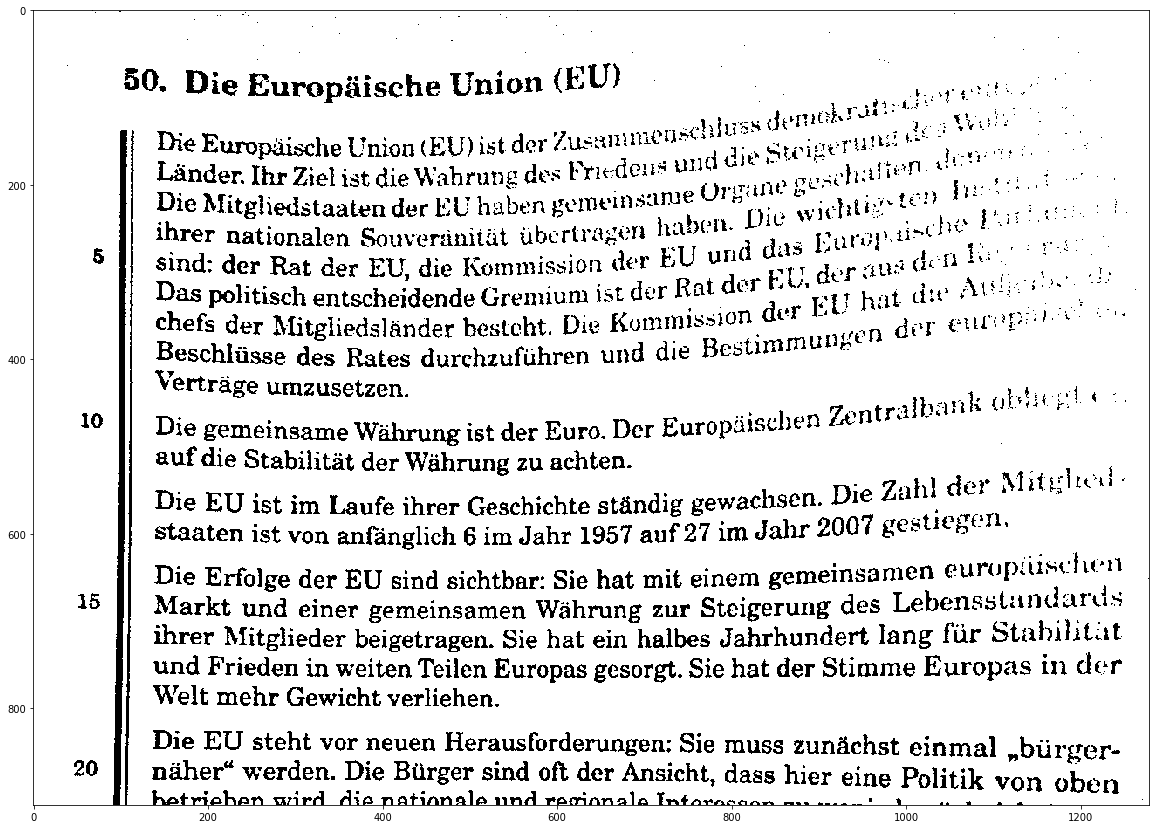

In [74]:
gray_image1 = gray_image1.astype(np.uint8)
test1 = cv2.adaptiveThreshold(gray_image1,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,57,15)
plt.figure(figsize=(20,15))
plt.imshow(test1, cmap="gray")
#plt.savefig('./ada_need_adiust.png',dpi = 500, bbox_inches = 'tight')
plt.show()

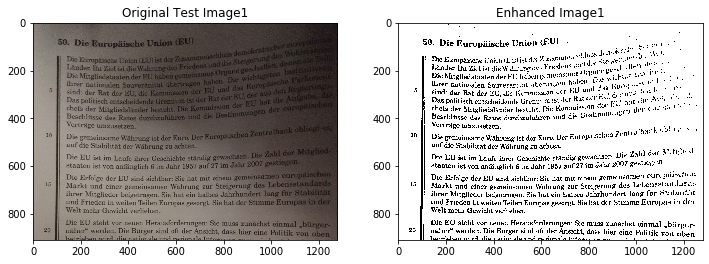

In [61]:
plt.figure('test1: image comparison', figsize=(12,4))
plt.subplot(1,2,1, title='Original Test Image1')
plt.imshow(image1, cmap='gray')
plt.subplot(1,2,2, title='Enhanced Image1')
plt.imshow(test1, cmap='gray')
#plt.savefig('./test1.png',dpi = 500, bbox_inches = 'tight')
plt.show()

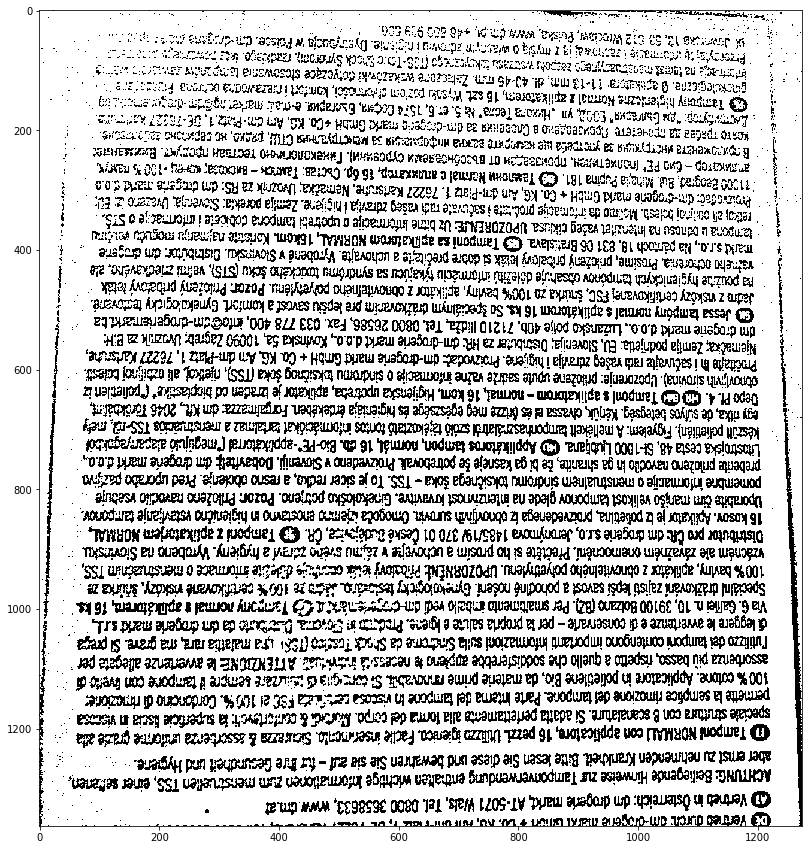

In [55]:
gray_image2 = gray_image2.astype(np.uint8)
test2 = cv2.adaptiveThreshold(gray_image2,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,37,8)
plt.figure(figsize=(20,15))
plt.imshow(test2, cmap="gray")
#plt.savefig('./ada_need_adiust.png',dpi = 500, bbox_inches = 'tight')
plt.show()

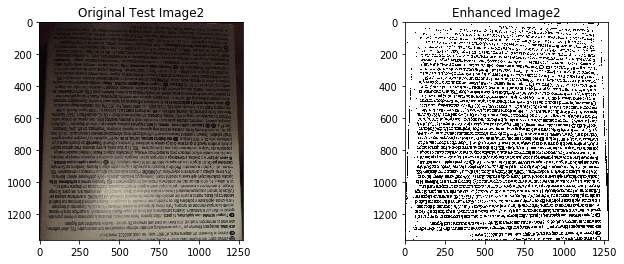

In [60]:
plt.figure('test2: image comparison', figsize=(12,4))
plt.subplot(1,2,1, title='Original Test Image2')
plt.imshow(image2, cmap='gray')
plt.subplot(1,2,2, title='Enhanced Image2')
plt.imshow(test2, cmap='gray')
plt.savefig('./test2.png',dpi = 500, bbox_inches = 'tight')
plt.show()

In [65]:

for ax in axes.ravel():
    print(ax)

AxesSubplot(0.125,0.657941;0.352273x0.222059)
AxesSubplot(0.547727,0.657941;0.352273x0.222059)
AxesSubplot(0.125,0.391471;0.352273x0.222059)
AxesSubplot(0.547727,0.391471;0.352273x0.222059)
AxesSubplot(0.125,0.125;0.352273x0.222059)
AxesSubplot(0.547727,0.125;0.352273x0.222059)


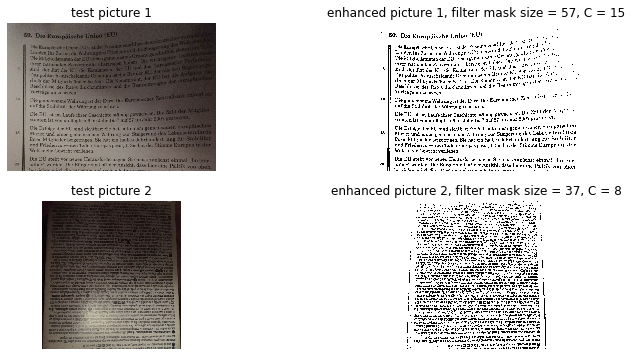

In [91]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure('test2: image comparison', figsize=(12,6))

#plot 1:
plt.subplot(2, 2, 1)
plt.imshow(image1, cmap='gray')
plt.axis('off')
plt.title("test picture 1")

#plot 2:
plt.subplot(2, 2, 2)
plt.imshow(test1, cmap='gray')
plt.axis('off')
plt.title("enhanced picture 1, filter mask size = 57, C = 15")

#plot 3:
plt.subplot(2, 2, 3)
plt.imshow(image2, cmap='gray')
plt.axis('off')
plt.title("test picture 2")

#plot 4:
plt.subplot(2, 2, 4)
plt.imshow(test2, cmap='gray')
plt.axis('off')
plt.title("enhanced picture 2, filter mask size = 37, C = 8")

#plt.savefig('./test.png',dpi = 500, bbox_inches = 'tight')

#plt.suptitle("RUNOOB subplot Test")
plt.show()